# Coursework

学生信息：


Importing all libraries

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Any, List, Sequence, Tuple

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
# import seaborn as sns

## Data preparation

### Data import

In [3]:
data_file = 'pue.csv'
all_data = np.genfromtxt(data_file, 
                         delimiter=',', 
                         skip_header=1, 
                         skip_footer=5, 
                         dtype=np.float64, # check casting
                         encoding='gb2312')

### Picking features

In [4]:
from sklearn.decomposition import PCA

# x 输入数据
# reduction_components 降维到多少维（2或3）
def pca_reduction(x, reduction_components):
    pca = PCA(n_components = reduction_components) # 降维
    pca.fit(x) # 训练
    newX = pca.fit_transform(x) # 降维后的数据
    
    return newX

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


# normalize 是否进行归一化
# reduction 是否降维
# select_count 特征选择的个数
# reduction_components 降维到多少维（2或3）
def feature_selection(data, normalize=True, reduction=True, select_count=10, reduction_components=2, cast_to_type=None):
    
    # TODO: change into one cycle
    # 数据
    x_64 = data[:, :64].copy().astype(np.float32)                    # 前64维
    x_other = data[:, 64:-2].copy()               # 非前64维
    if cast_to_type is not None and type(all_data[0,0]) is not cast_to_type:
        x_other = x_other.astype(cast_to_type)
    y = data[:, -1].copy()                        # pue 
    time = data[:, -2].copy()                     # time
    
    # 归一化，所有特征都进行归一化
    if normalize == True:       
        scaler = MinMaxScaler()   
        x_64 = scaler.fit_transform(x_64)
        x_other = scaler.fit_transform(x_other)

    # 特征选择，只对【非前64维度的特征】进行特征选择
    fs = SelectKBest(score_func=f_regression, k=select_count)
    X_selected = fs.fit_transform(x_other, y)

    
    # PCA降维
    if reduction == True:
        X_selected = pca_reduction(X_selected, reduction_components)

        
    # 将前64维和处理后的特征拼接在一起
    return np.append(x_64,X_selected,axis=1), y, time

In [6]:
# 结果 = 前64维 + 【非前64维特征】特征选择后的特征

X, Y, time = feature_selection(all_data, reduction=False, select_count=20, cast_to_type=np.float32) 


print(X.shape)
print(Y.shape)
print(time.shape)

(2272, 84)
(2272,)
(2272,)


/Users/Alexey/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/Alexey/miniconda3/envs/deeplearning/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


#### window + data split
> 目前比使用

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#     series = tf.expand_dims(series, axis=-1)

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    
    return ds.batch(batch_size).prefetch(1)

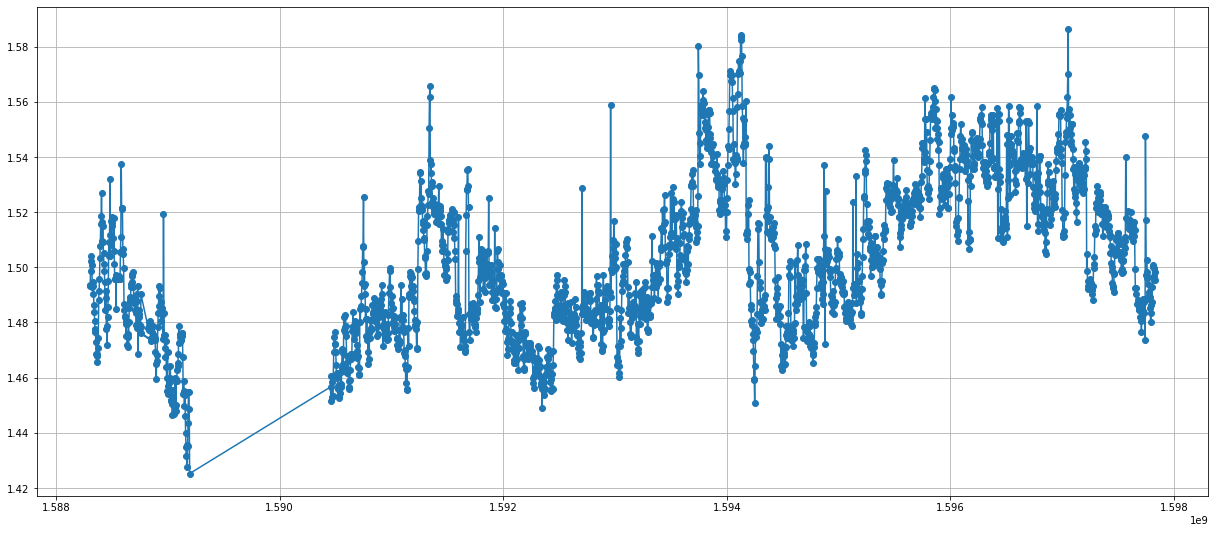

In [8]:
plt.figure(figsize=(21, 9))
plt.plot(time, Y, '-o')
# plt.legend(loc=1)
plt.grid(True)

In [9]:
split_time = 2048
window_size = 32
batch_size = 64
shuffle_buffer_size = 512

time_train = time[:split_time]
x_train = X[:split_time]
y_train = Y[:split_time]

time_valid = time[split_time:]
x_valid = X[split_time:]
y_valid = Y[split_time:]
# t_set = np.column_stack((x_train, y_train))

x_train = np.expand_dims(x_train, axis=1)
x_valid = np.expand_dims(x_valid, axis=1)
y_train = np.expand_dims(y_train, axis=1)
y_valid = np.expand_dims(y_valid, axis=1)

In [10]:
# train_set = windowed_dataset(t_set, window_size, batch_size, shuffle_buffer_size)

# print(x_train.shape)
# print(train_set)

## Define model

First run is for checking which learning rate produces lowest loss

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
#     plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

1. 在这里先指定想训练的模型机构：层数，神经数，optimizer，loss，等等。也试一下多种数据状态
2. 然后看一下图，可以选learning_rate，对adam、nadam、等等optimizer，可以跳过去这一步
3. 每次调参数后使用`plot_learning_curves`来判断有没有overfitting什么的。
4. 我还推荐使用 `keras.callbacks.EarlyStopping` 和 `keras.callbacks.ModelCheckpoint`
5. 如果觉得训练了比较好的模型，自己保存到文档

In [12]:
# tf.keras.backend.clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input(shape=[None, x_train.shape[-1]]),
#     tf.keras.layers.Conv1D(filters=32, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#     ),
#     tf.keras.layers.LSTM(64, return_sequences=True),
#     tf.keras.layers.LSTM(64, return_sequences=True),
#     tf.keras.layers.Dense(30, activation="relu"),
#     tf.keras.layers.Dense(10, activation="relu"),
#     tf.keras.layers.Dense(1),

# ])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))

# optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])

# # model.summary()

In [13]:
# history = model.fit(x_train,y_train, 
#                     epochs=100, 
#                     callbacks=[lr_schedule]
#                    )

Plot first run results, and the lowest loss is around `lr = 1e-4`

In [14]:
# plt.figure(figsize=(10, 5))
# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 9e-4, 0, 1])

### Improving model architecture + Finetuning
> TODO：调模型参数

### Actual training

In [15]:
class EndEpochResetState(tf.keras.callbacks.Callback):
    def __init__(self):
        pass
    def on_epoch_end(self, epoch, logs=None):
        self.model.reset_states()

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[None, x_train.shape[-1]], batch_size=32),
  tf.keras.layers.Conv1D(filters=64, 
                         kernel_size=5,
                         strides=1, 
                         padding="causal",
                         activation="relu",
                        ),
    
  tf.keras.layers.LSTM(512, return_sequences=True, stateful=True),
  tf.keras.layers.LSTM(128, return_sequences=True, stateful=True),
  tf.keras.layers.Dense(128, activation="elu"),
  tf.keras.layers.Dense(64, activation="elu"),
  tf.keras.layers.Dense(1),

])

optimizer = tf.keras.optimizers.Nadam()

model.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=["mae"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (32, None, 64)            26944     
_________________________________________________________________
lstm (LSTM)                  (32, None, 512)           1181696   
_________________________________________________________________
lstm_1 (LSTM)                (32, None, 128)           328192    
_________________________________________________________________
dense (Dense)                (32, None, 128)           16512     
_________________________________________________________________
dense_1 (Dense)              (32, None, 64)            8256      
_________________________________________________________________
dense_2 (Dense)              (32, None, 1)             65        
Total params: 1,561,665
Trainable params: 1,561,665
Non-trainable params: 0
______________________________________________

In [17]:
epochs = 10
history = model.fit(x_train, y_train, epochs=epochs,
                   validation_data=(x_valid,y_valid),
                    callbacks=[EndEpochResetState()]
                   )

Epoch 1/10
64/64 [==============================] - 2s 30ms/step - loss: 0.1087 - mae: 0.1334 - val_loss: 0.0023 - val_mae: 0.0424
Epoch 2/10
64/64 [==============================] - 1s 23ms/step - loss: 0.0429 - mae: 0.0710 - val_loss: 0.0014 - val_mae: 0.0333
Epoch 3/10
64/64 [==============================] - 1s 23ms/step - loss: 0.0185 - mae: 0.0555 - val_loss: 0.0014 - val_mae: 0.0340
Epoch 4/10
64/64 [==============================] - 2s 24ms/step - loss: 0.0092 - mae: 0.0449 - val_loss: 8.6456e-04 - val_mae: 0.0263
Epoch 5/10
64/64 [==============================] - 1s 22ms/step - loss: 0.0031 - mae: 0.0298 - val_loss: 0.0021 - val_mae: 0.0437
Epoch 6/10
64/64 [==============================] - 1s 22ms/step - loss: 0.0020 - mae: 0.0341 - val_loss: 4.3573e-04 - val_mae: 0.0168
Epoch 7/10
64/64 [==============================] - 1s 22ms/step - loss: 0.0010 - mae: 0.0233 - val_loss: 3.5356e-04 - val_mae: 0.0140
Epoch 8/10
64/64 [==============================] - 1s 22ms/step - loss

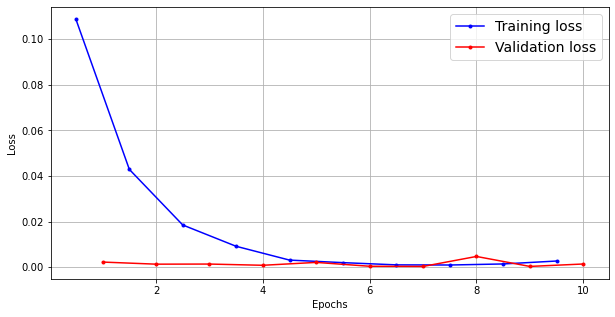

In [18]:
plt.figure(figsize=(10,5))
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Plotting forecast of a trained model

In [19]:
def plot_series(time, series, format="-", start=0, end=None, label=''):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc=3)
    plt.grid(True)

In [20]:
def model_forecast(model, series, window_size=32):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [21]:
# model.reset_metrics()
# rnn_forecast = model_forecast(model, x_valid)
rnn_forecast = model.predict(x_valid)
rnn_forecast = rnn_forecast[:, 0, 0]

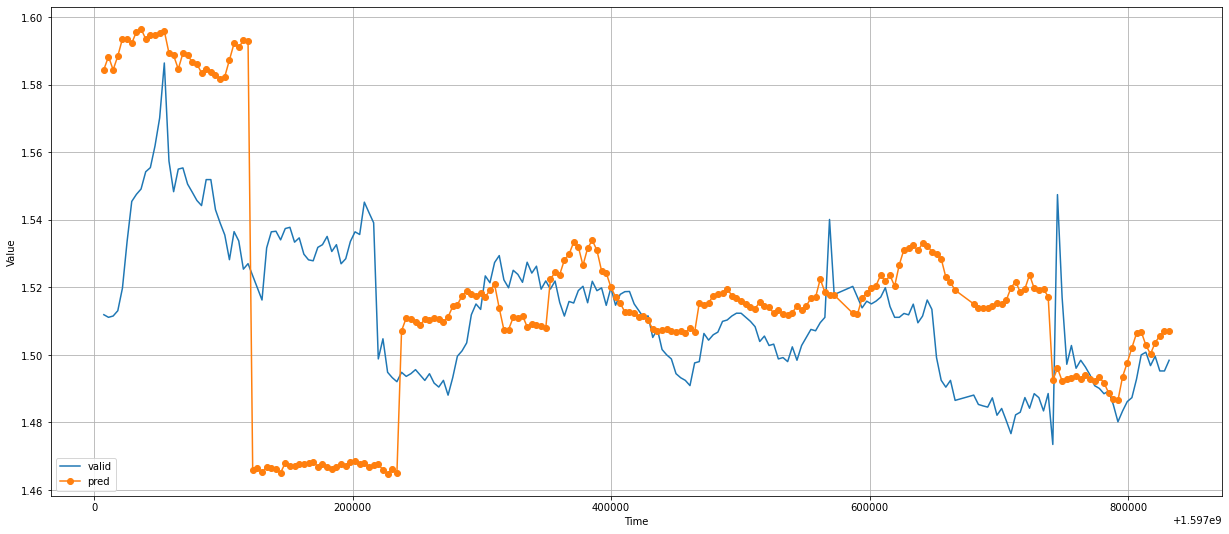

In [22]:
plt.figure(figsize=(21, 9))

# unseen vs 
plot_series(time_valid, y_valid, label='valid')
plot_series(time_valid, rnn_forecast, format='-o', label='pred')

actual mae

In [23]:
np.sum(tf.keras.metrics.mean_absolute_error(y_valid, rnn_forecast))

6.833041

## Reinforcement Learning
Firstly we create environment

In [24]:
class Environment:
    def __init__(self, model, ideal=1.0, scaler=1000):
        """
            `model`:  tensorflow.keras.model makes predictions
            `ideal`:  is a value we want our environment to return; optimizing to it
            `scaler`: scales reward
        """
        self.model = model
        self.ideal = ideal
        self.scaler = scaler
    
    def _forecast(self, data_series):
        """
            IMPORTANT: Only predicts by batches of 32, current limitation
        """
        return self.model.predict(data_series)
    

    def _calc_reward(self, actual: np.ndarray) -> np.ndarray:
        """
            IMPORTANT: negative of loss. Lower the loss, the better.

            Actually there's no need in abs(), because predicted PUE should 
            always be above 1.0, but such solution should be error resistant.

            returns: numpy.array
        """
        return np.negative(np.abs((actual-self.ideal) * self.scaler))
    
    
    def step(self, action):
        """
            Depricated
        """
        state = self._forecast(action)
        state = np.concatenate([action[:,0], state[:,0]], axis=-1)
        reward = self._calc_reward(pred_val)
        
        return state, reward

    # Wrap as an operation in a TensorFlow function.
    # This would allow it to be included in a callable TensorFlow graph.
    def env_step(self, action: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
            Returns state and reward given an action.
        """
        # state is predicted value
        state = self._forecast(action)
#         state = np.concatenate([action[:,0], state[:,0]], axis=-1)
#         print('shape of predicted val:', state.shape, 'and type:', type(state))
        reward = self._calc_reward(state)
#         print('shape of reward:', reward.shape, 'and type:', type(reward))
        return (state, reward)

    def tf_env_step(self, action: tf.Tensor) -> List[tf.Tensor]:
        return tf.numpy_function(self.env_step, [action], [tf.float32, tf.float32])
    
    def reset(self):
        # TODO: check which to use
        self.model.reset_states()
#         self.model.reset_metrics()
#         keras.backend.clear_session()

    

Then create Actor and Critic

In [169]:
class ActorCritic(tf.keras.Model):
    """Combined actor-critic network."""

    def __init__(self, 
#                  inp_state_dim: int,
                 num_actions: int, 
                 num_hidden_units: int):
        """Initialize."""
        
        super().__init__()

        self.common = tf.keras.layers.Dense(num_hidden_units, activation="elu")
        self.actor = tf.keras.layers.Dense(num_actions)
#         bullshiet = tf.keras.layers.Dense(num_hidden_units)
        self.critic = tf.keras.layers.Dense(1, activation='softmax')

    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        x = self.common(inputs)
#         x1 = self.common(x1)
#         x1 = self.common(x1)
        return self.actor(x), self.critic(x)

In [170]:
# actorCriticModel = ActorCritic(128, 84)
# actorCriticModel.summary

In [171]:
def run_episode(
    initial_state: tf.Tensor,  
    agent: tf.keras.Model, 
    max_steps: int) -> List[tf.Tensor]:
    """Runs a single episode to collect training data."""
    print("------ RUN EPISODE ------")
    actions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values  = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, infer_shape=False)

    initial_state_shape = initial_state.shape
    state = initial_state
#     print(f"initial state shape {initial_state.shape}" )
    
    for t in tf.range(max_steps):
        # Convert state into a batched tensor (batch size = 1)
#         state = tf.expand_dims(state, 0)
#         print(f"actual inp state shape {state.shape}" )
        # Run the model and to get action probabilities and critic value
        tf.debugging.assert_all_finite(state, message="state fed into agent has problems")
        action, value = agent(state)
        
#         tf.print(action)
        tf.debugging.assert_all_finite(value, message="value received from agent has problems")
        tf.debugging.assert_all_finite(action, message="action received from agent has problems")
#         print(f"action shape {action.shape}" )
#         pred, value = agent(state)

        # Store critic values
        values = values.write(t, tf.squeeze(value))
#         print(f"run_episode values shape {values.element_shape}" )

        # Store log of the action chosen
        actions = actions.write(t, action)
#         print(f"run_episode actions shape {actions.element_shape}" )

        # Apply action to the environment to get next state and reward
#         print("action shape as it should be:", tf.expand_dims(action, 1).shape)
        pred_state, reward = env.tf_env_step(tf.expand_dims(action, 1))
        
#         np.concatenate([action[:,0], state[:,0]], axis=-1)
#         print("pred_state shape", tf.shape(pred_state))
#         print(f"run_episode reward shape {tf.shape(reward)}")
#         print("concat shapes a p:", tf.squeeze(action), tf.squeeze(pred_state, 1))
        state = tf.concat([tf.squeeze(action), tf.squeeze(pred_state, 1)], 1)
#         state = tf.concat(action, pred_state, axis=-1)

#         print(f"run_episode state shape {state.shape}")
        state.set_shape(initial_state_shape)
        reward.set_shape(initial_state.shape[0:1])
        tf.squeeze(reward)
#         print(f"run_episode reward after shaping! {reward.shape}")

        # Store reward
        rewards = rewards.write(t, reward)

#     print("BEFORE stacking a v r:", actions.element_shape, values.element_shape, rewards.element_shape)
    actions = actions.stack()
    values = values.stack()
    
    rewards = rewards.stack()
#     print("a v r:", actions.shape, values.shape, rewards.shape)
    
    return actions, values, rewards

In [172]:
# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
    """Compute expected returns per timestep."""

    n1 = tf.shape(rewards)[0] # num of episodes = 64
    n2 = tf.shape(rewards)[1] # batch size      = 32
#     tf.print(tf.shape(rewards))
    returns = tf.TensorArray(dtype=tf.float32, size=n1, infer_shape=False)

    # Start from the end of `rewards` and accumulate reward sums
    # into the `returns` array
#     print("BEFORE CAST rewards shape", tf.shape(rewards))
#     print("->", rewards[::-1])
#     rewards = tf.cast(rewards[::-1], dtype=tf.float32)
#     print("AFTER CAST reward shape", tf.shape(rewards))

    for j in tf.range(n1):
        discounted_sum = tf.constant(0.0)
        discounted_sum_shape = discounted_sum.shape
#         tf.print(discounted_sum)
        for i in tf.range(n2):
            reward = rewards[j, i]
            discounted_sum = reward + gamma * discounted_sum
            discounted_sum.set_shape(discounted_sum_shape)
            returns = returns.write(i, discounted_sum)
#     print('BEFORE: returns shape', returns.element_shape, type(returns))

#     returns = returns.stack()[::-1]
    returns = returns.stack()
#     print('AFTER: returns shape', returns.shape)

    if standardize:
        returns = ((returns - tf.math.reduce_mean(returns)) / 
                   (tf.math.reduce_std(returns) + eps))

    return returns

In [240]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    actions: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
    """Computes the combined actor-critic loss."""

    advantage = returns - values
#     tf.print(advantage)
#     print("advantage shape:", advantage.shape)
    tf.print(actions.shape)
    tf.debugging.assert_all_finite(actions, message="actions has problems")
    actions_log = tf.math.reduce_mean(tf.math.exp(actions + eps), -1)
    tf.debugging.assert_all_finite(actions_log, message="actions_log has problems")
#     print("actions_log shape:", actions_log.shape)
#     print(action_log_probs)
    actor_loss = tf.math.reduce_sum(actions_log * advantage)
    tf.debugging.assert_all_finite(actions_log, message="actor_loss has problems")
#     print("actor loss shape", actor_loss.shape)
    
    critic_loss = huber_loss(values, returns)
    tf.print(actor_loss)
    tf.print(critic_loss)
    tf.debugging.assert_all_finite(actions_log, message="critic_loss has problems")
#     print("critic loss shape", critic_loss.shape)
#     print("actor loss:", int(actor_loss), "critic loss:", int(critic_loss))
    
    return actor_loss + critic_loss

In [241]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(
    initial_state: tf.Tensor, 
    agent: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
    """
        Runs a model training step.
    """

    with tf.GradientTape() as tape:

        # Run the model for one episode to collect training data
#         print(1)
        actions, values, rewards = run_episode(initial_state, agent, max_steps_per_episode) 
#         print("before expanding dims a v rewards:", actions.shape, values.shape, rewards.shape)
        # Calculate expected returns
#         print(2)
        returns = get_expected_return(rewards, gamma)
        # Convert training data to appropriate TF tensor shapes
        actions, values, returns = [tf.expand_dims(x, 1) for x in [actions, values, returns]] 
#         print("after expanding dims a v returns:", actions.shape, values.shape, returns.shape)
        # Calculating loss values to update our network
#         print(3)
        loss = compute_loss(actions, values, returns)

    # Compute the gradients from the loss
#     print(4)
    tf.debugging.assert_all_finite(loss, message="loss has problems")
    grads = tape.gradient(loss, agent.trainable_variables) # <- FIX THIS BULLSHIT

    # Apply the gradients to the model's parameters
#     print(5)
    optimizer.apply_gradients(zip(grads, agent.trainable_variables))
    episode_reward = tf.math.reduce_sum(rewards)
#     print("EPISODE REWARD", int(episode_reward))
    return episode_reward

And finally start optimizing on the environment


In [271]:
for z in tf.range(1):
    state = initial_state
    rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    actions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

    for t in tf.range(3):
        action, value = actorCriticModel(state)
        pred, reward = env.tf_env_step(x_train[1:33])
        values = values.write(t, tf.squeeze(value))
        actions = actions.write(t, action)
        rewards = rewards.write(t, tf.squeeze(reward))
        state = tf.concat([tf.squeeze(action), tf.squeeze(pred, 1)], 1)
        state.set_shape(initial_state.shape)
    
    values = values.stack()
    actions = actions.stack()
    rewards = rewards.stack()

    
    n1 = tf.shape(rewards)[0] # num of episodes = 10
    n2 = tf.shape(rewards)[1] # batch size      = 32
    
    returns = tf.TensorArray(dtype=tf.float32, size=n1)

    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape


    for j in tf.range(n2):
        discounted_sum = tf.constant(0.0)
        discounted_sum_shape = discounted_sum.shape
#         tf.print(discounted_sum)
        for i in tf.range(n1):
            reward = rewards[i, j]
            discounted_sum = reward + gamma * discounted_sum
            discounted_sum.set_shape(discounted_sum_shape)
            returns = returns.write(i, discounted_sum)


    returns = returns.stack()

    returns = ((returns - tf.math.reduce_mean(returns)) / (tf.math.reduce_std(returns) + eps))

#     print("mean returns", returns)
    
    actions, values, returns = [tf.expand_dims(x, 1) for x in [actions, values, returns]] 

    tf.print(actions.shape)
    tf.print(actions)
    
    advantage = returns - values
    #     print("advantage shape:", advantage.shape)
#     print("advantage:", advantage)

    actions_log = tf.math.reduce_mean(tf.math.log_softmax(actions + eps), -1)
#     tf.print(actions_log)

    actor_loss = tf.math.reduce_sum(actions_log * advantage)
    tf.print(actor_loss)

    critic_loss = huber_loss(values, returns)
    print("critic loss shape", tf.shape(critic_loss))
    #     print("actor loss:", int(actor_loss), "critic loss:", int(critic_loss))
    loss = actor_loss + critic_loss
    print("-> total loss", loss)

    print(int(tf.math.reduce_sum(rewards)))

TensorShape([3, 1, 32, 84])
[[[[-0.742641211 -0.00556311384 0.998833418 ... 0.491740882 -0.273630559 -0.467265636]
   [-0.74078989 -0.0130463345 0.996910095 ... 0.502033889 -0.27332297 -0.463583946]
   [-0.739318192 -0.0119586913 0.995734334 ... 0.506033421 -0.272062898 -0.463629842]
   ...
   [-0.74481684 -0.01278196 0.999070048 ... 0.512114644 -0.265903 -0.465096]
   [-0.744185388 -0.0127519267 0.996712327 ... 0.510592937 -0.263501257 -0.45968315]
   [-0.742724538 -0.0106154131 0.992175341 ... 0.524117351 -0.26708141 -0.459239423]]]


 [[[-0.793244183 0.860834 0.712331414 ... 1.39846718 -0.839959264 -0.717822552]
   [-0.783934832 0.856481969 0.71610105 ... 1.40286469 -0.830974579 -0.724973321]
   [-0.785673738 0.854080141 0.716129 ... 1.40173793 -0.82533139 -0.724488914]
   ...
   [-0.790286958 0.850951552 0.712710917 ... 1.40613425 -0.823848367 -0.740946889]
   [-0.786691666 0.850982308 0.712237 ... 1.40261376 -0.823840201 -0.737556279]
   [-0.786901116 0.850841761 0.710483849 ... 1

In [243]:
n_iterations = 5000
n_episodes = 32
gamma = 0.9998

env = Environment(model, scaler=10)
num_actions = model.input_shape[2] # +1 PUE
num_hidden_units = 128
initial_state = np.concatenate([x_train[1:33,0], y_train[:32]], axis=-1)
initial_state = initial_state.astype(np.float32)


actorCriticModel = ActorCritic(num_actions, num_hidden_units)

In [244]:
import contextlib

@contextlib.contextmanager
def options(options):
  old_opts = tf.config.optimizer.get_experimental_options()
  tf.config.optimizer.set_experimental_options(options)
  try:
    yield
  finally:
    tf.config.optimizer.set_experimental_options(old_opts)

In [245]:
print(tf.config.optimizer.get_experimental_options())
# tf.config.threading.set_inter_op_parallelism_threads(1)

{'disable_model_pruning': False, 'disable_meta_optimizer': False}


In [246]:
# with options({ 'disable_model_pruning':True, 'disable_meta_optimizer': True}):
#     print(tf.config.optimizer.get_experimental_options())
#     train_step(
#         initial_state, 
#         actorCriticModel, 
#         optimizer,
#         gamma, 
#         n_episodes
#     )

In [247]:
%%time
import tqdm
n_episodes = 1000
n_steps = 64


# consecutive trials
reward_threshold = -5
running_reward = 0

# Discount factor for future rewards
gamma = 0.9998

with tqdm.trange(n_episodes) as t:
    for i in t:
        env.reset()
        initial_state = np.concatenate([x_train[1:33,0], y_train[:32]], axis=-1)
        initial_state = initial_state.astype(np.float32)
        episode_reward_ = train_step(
            initial_state, actorCriticModel, optimizer, gamma, n_steps)
        tf.debugging.assert_all_finite(episode_reward_, message="running reward has problems")
        episode_reward = int(episode_reward_)
        running_reward = episode_reward*0.01 + running_reward*.99

        t.set_description(f'Episode {i}')
        t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)


        if running_reward > reward_threshold:  
            break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|          | 0/1000 [00:00<?, ?it/s]

------ RUN EPISODE ------
------ RUN EPISODE ------
TensorShape([None, 1, 32, 84])
-138598.078
42.5440369


Episode 0:   0%|          | 1/1000 [00:03<50:51,  3.05s/it, episode_reward=-1251, running_reward=-12.5]

TensorShape([None, 1, 32, 84])


Episode 0:   0%|          | 1/1000 [00:04<1:16:40,  4.61s/it, episode_reward=-1251, running_reward=-12.5]


InvalidArgumentError:  actions_log has problems : Tensor had Inf values
	 [[node VerifyFinite_1/CheckNumerics (defined at <ipython-input-240-28887938ac6c>:15) ]] [Op:__inference_train_step_893595]

Errors may have originated from an input operation.
Input Source operations connected to node VerifyFinite_1/CheckNumerics:
 Mean_1 (defined at <ipython-input-240-28887938ac6c>:14)	
 VerifyFinite/CheckNumerics (defined at <ipython-input-240-28887938ac6c>:13)

Function call stack:
train_step


In [222]:
state = initial_state
actions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
values  = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

for t in tf.range(10):
    action, value = actorCriticModel(state)
    print("ACTION", action)
    pred_state, reward = env.tf_env_step(tf.expand_dims(action, 1))
    values = values.write(t, tf.squeeze(value))
    rewards = rewards.write(t, reward)

    # Store log of the action chosen
    actions = actions.write(t, action)
    
    state = tf.concat([tf.squeeze(action), tf.squeeze(pred_state, 1)], 1)
    state.set_shape(initial_state.shape)
    print(state.shape)


ACTION tf.Tensor(
[[-1.1889801   1.1131787  -0.30109805 ... -0.03657325  0.43983185
   0.7764006 ]
 [-1.1980689   1.1189734  -0.3005811  ... -0.0412645   0.44671318
   0.77048117]
 [-1.1992795   1.1200311  -0.29824322 ... -0.04730829  0.44880697
   0.7708615 ]
 ...
 [-1.1867313   1.1185701  -0.30003086 ... -0.0518431   0.42898232
   0.77797246]
 [-1.1877403   1.1141622  -0.3042678  ... -0.04982468  0.4303565
   0.7778906 ]
 [-1.1911552   1.1116997  -0.30938834 ... -0.03890996  0.42779785
   0.78628546]], shape=(32, 84), dtype=float32)
(32, 85)
ACTION tf.Tensor(
[[ 0.5452878   1.0426946  -0.583248   ...  0.8679468  -0.84653807
   0.747046  ]
 [ 0.54801214  1.0302018  -0.5734175  ...  0.86757404 -0.8477948
   0.74809086]
 [ 0.54941785  1.0287154  -0.57583946 ...  0.8708352  -0.8492764
   0.74894   ]
 ...
 [ 0.5349833   1.0408323  -0.5801654  ...  0.8783603  -0.8458495
   0.7537441 ]
 [ 0.5381305   1.0391409  -0.5799034  ...  0.8766606  -0.8452751
   0.7498374 ]
 [ 0.5411357   1.0416672  

In [55]:
actions.element_shape

TensorShape([32, 84])

In [ ]:

ep_rewards = []
for episode in range(n_iterations):
    ep_reward = 0
    for step in range(n_episodes):
        action = policy.next_action(next_state)
        step_reward, next_state = env.step(action)
        ep_reward += step_reward
    
    ep_rewards.append(ep_reward)
    policy.update(ep_reward)
    env.reset()

In [ ]:
class Actor:
    def __init__(self):
        self.model = self._create_model()
        self.target_model = self._create_model()
        #copy weights ?
    
    def _create_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=[None, x_train.shape[-1]]),
            tf.keras.layers.Input(shape=[None, x_train.shape[-1]]),
            tf.keras.layers.Dense(64, activation="relu", kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(64, activation="relu", kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(64, activation="relu", kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(64, activation="relu", kernel_initializer='lecun_normal'),
        ])
        model.compile(loss="mse", optimizer="adam")
        
        return model
    
    def next_exploration_action(self, state):
        return self.model.predict(state) + gen_noise(dimensions)
    
    def next_action(self, state):
        return self.target_model.predict(state)
    
    def train(self, samples):
        for sample in samples:
            cur_state, action, reward, new_state, _ = sample
            predicted_action = self.actor_model.predict(cur_state)
            grads = self.sess.run(self.critic_grads, feed_dict={
                self.critic_state_input:  cur_state,
                self.critic_action_input: predicted_action
            })[0]

            self.sess.run(self.optimize, feed_dict={
                self.actor_state_input: cur_state,
                self.actor_critic_grad: grads
            })
            
    # only for model, target model doesn't need it    
    @property
    def trainable_weights(self):
        return self.model.trainable_weights
    
    # only for model, target model doesn't need it
    @property
    def output(self):
        return self.model.output
        

class Critic:
    def __init__(self):
        self.model = self._create_model()
        
    def _create_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=[None, x_train.shape[-1]]),
            tf.keras.layers.Dense(64, activation="relu", kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(64, activation="relu", kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(64, activation="relu", kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(64, activation="relu", kernel_initializer='lecun_normal'),
        ])
        model.compile(loss="mse", optimizer="adam")
        
        return model

    @tf.function
    def train(self, samples):
        for sample in samples:
            cur_state, action, reward, new_state = sample
#            because we don't have `done`, we don't do it

#            if not done:
#            target_action = self.target_actor_model.predict(new_state)
#            future_reward = self.target_critic_model.predict(
#               [new_state, target_action])[0][0]
#               reward += self.gamma * future_reward
            self.model.fit([cur_state, action], reward, verbose=0)
    
    @property
    def output(self):
        return self.model.output
        

In [ ]:
from collections import deque

# Actor-Critic
class Agent:
    def __init__(self):
        self.actor = Actor()
        self.critic = Critic()
        
        self.memory = deque(maxlen=25_000)
        self.learning_rate = 0.001         # TODO: do smth with lr

        # where we will feed de/dC (from critic)
        # TODO: change action_space shape !
        self.agent_grad = tf.placeholder(tf.float32, [None, self.env.action_space.shape[0]])

        ##################
        #   actor part   #
        ##################
        actor_model_weights = self.actor_model.trainable_weights
        self.actor_grads = tf.gradients(self.actor.output, actor_model_weights, -self.agent_grad) # dC/dA (from actor)
        grads = zip(self.actor_grads, actor_model_weights)
        
#         self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)
        
        ##################
        #   critic part  #
        ##################
        # TODO: originally grads wrt action_input part only, not state_input part
        self.critic_grads = tf.gradients(self.critic.output, self.critic_input)

        
    def train(self):
        batch_size = 32
        if len(self.memory) < batch_size:
            return

        samples = random.sample(self.memory, batch_size)
        
        self.critic.train(samples)
        
        for sample in samples:
            
            cur_state, action, reward, new_state = sample
            predicted_action = self.actor.predict(cur_state)
            
            # TODO: find out why it's here
#             self.critic_state_input = cur_state
            # TODO: check if only [0]'s element is required
            grad = tf.gradients(self.critic.output, predicted_action)[0]         #new
            
            actor_grads = tf.gradients(self.actor.output, self.actor.trainable_weights, -grad) # dC/dA (from actor)
            grads = zip(actor_grads, self.actor.trainable_weights)
            tf.keras.optimizers.Adam(self.learning_rate).apply_gradients(grads)
#             tf.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)

    def remember(self, cur_state, action, reward, new_state):
        self.memory.append([cur_state, action, reward, new_state])
        